# Word2Vec (Skipgram )

In [57]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [58]:
np.__version__, torch.__version__

('1.23.5', '1.13.1')

In [59]:
import matplotlib
matplotlib.__version__

'3.6.2'

## 1. Load data

In [60]:

import nltk
from nltk.corpus import webtext
nltk.download('webtext')

[nltk_data] Downloading package webtext to
[nltk_data]     /Users/sapnathapa/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

### Tokenize

In [61]:
corpus_tokenized = webtext.sents()[:500]

In [62]:
corpus_tokenized[0]

['Cookie',
 'Manager',
 ':',
 '"',
 'Don',
 "'",
 't',
 'allow',
 'sites',
 'that',
 'set',
 'removed',
 'cookies',
 'to',
 'set',
 'future',
 'cookies',
 '"',
 'should',
 'stay',
 'checked',
 'When',
 'in',
 'full',
 'screen',
 'mode',
 'Pressing',
 'Ctrl',
 '-',
 'N',
 'should',
 'open',
 'a',
 'new',
 'browser',
 'when',
 'only',
 'download',
 'dialog',
 'is',
 'left',
 'open',
 'add',
 'icons',
 'to',
 'context',
 'menu',
 'So',
 'called',
 '"',
 'tab',
 'bar',
 '"',
 'should',
 'be',
 'made',
 'a',
 'proper',
 'toolbar',
 'or',
 'given',
 'the',
 'ability',
 'collapse',
 '/',
 'expand',
 '.']

### Numericalize

In [63]:
#getting the unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [65]:
#add <unk>
word2index = dict()
word2index['<unk>'] = 0 

In [66]:
word2index['<unk>']

0

In [67]:
#assiging id to all the vocabs
for index, vocab in enumerate(vocabs):
    word2index[vocab] = index + 1
vocabs.append('<unk>')

In [68]:
word2index

{'<unk>': 0,
 'Blocking': 1,
 'Lake': 2,
 'firebird': 3,
 'changing': 4,
 'vertical': 5,
 'Opera': 6,
 'holds': 7,
 'Menu': 8,
 'Failure': 9,
 'Why': 10,
 'ifdeffing': 11,
 '?"': 12,
 'FM': 13,
 'Editing': 14,
 'partially': 15,
 'FAILS': 16,
 'objdir': 17,
 'Certificates': 18,
 'FIrebird': 19,
 'Startup': 20,
 'XPI': 21,
 'Photo': 22,
 'check': 23,
 'gtk_init': 24,
 'backslash': 25,
 'expect': 26,
 'requests': 27,
 'favourite': 28,
 'colors': 29,
 'Up': 30,
 'compress': 31,
 'correctly': 32,
 '20030818': 33,
 'Sorts': 34,
 'Improvement': 35,
 'XPInstall': 36,
 'Dlg': 37,
 'playback': 38,
 'li': 39,
 'OBJECT': 40,
 'given': 41,
 'Extension': 42,
 'Window': 43,
 'PNG': 44,
 'Colored': 45,
 'Virtual': 46,
 'Currently': 47,
 'severe': 48,
 '...:': 49,
 'Entity': 50,
 'completes': 51,
 'narrow': 52,
 'screen': 53,
 '10th': 54,
 '12MB': 55,
 'Wallpaper': 56,
 'please': 57,
 'Highlighting': 58,
 'configuring': 59,
 'Maybe': 60,
 'tried': 61,
 'happen': 62,
 '25': 63,
 'reflect': 64,
 'Method'

In [69]:
#creating index2word dict
#just in case we need to use
index2word = {v:k for k, v in word2index.items()}
index2word 

{0: '<unk>',
 1: 'Blocking',
 2: 'Lake',
 3: 'firebird',
 4: 'changing',
 5: 'vertical',
 6: 'Opera',
 7: 'holds',
 8: 'Menu',
 9: 'Failure',
 10: 'Why',
 11: 'ifdeffing',
 12: '?"',
 13: 'FM',
 14: 'Editing',
 15: 'partially',
 16: 'FAILS',
 17: 'objdir',
 18: 'Certificates',
 19: 'FIrebird',
 20: 'Startup',
 21: 'XPI',
 22: 'Photo',
 23: 'check',
 24: 'gtk_init',
 25: 'backslash',
 26: 'expect',
 27: 'requests',
 28: 'favourite',
 29: 'colors',
 30: 'Up',
 31: 'compress',
 32: 'correctly',
 33: '20030818',
 34: 'Sorts',
 35: 'Improvement',
 36: 'XPInstall',
 37: 'Dlg',
 38: 'playback',
 39: 'li',
 40: 'OBJECT',
 41: 'given',
 42: 'Extension',
 43: 'Window',
 44: 'PNG',
 45: 'Colored',
 46: 'Virtual',
 47: 'Currently',
 48: 'severe',
 49: '...:',
 50: 'Entity',
 51: 'completes',
 52: 'narrow',
 53: 'screen',
 54: '10th',
 55: '12MB',
 56: 'Wallpaper',
 57: 'please',
 58: 'Highlighting',
 59: 'configuring',
 60: 'Maybe',
 61: 'tried',
 62: 'happen',
 63: '25',
 64: 'reflect',
 65: 'Met

## 2. Prepare train data

In [70]:
def random_batch(batch_size, corpus, window_size=1):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [71]:
input, label = random_batch(10, corpus_tokenized, 2)

print(f"{input.shape}")
print(f"{input=}")
print(f"{label=}")

(10, 1)
input=array([[3873],
       [ 373],
       [4393],
       [2183],
       [4889],
       [3662],
       [ 190],
       [4680],
       [3636],
       [ 271]])
label=array([[2575],
       [3994],
       [4515],
       [1378],
       [4191],
       [ 228],
       [4785],
       [1853],
       [3297],
       [4780]])


# 3. Model

In [72]:
class Skipgram(nn.Module):
    '''
        Skipgram implementation 
        class that accepts the parameter vocabulary
        size and embedding size
    '''
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term) 
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        
        return loss_fn

In [73]:
#testing the method
batch_size = 2 #mini-batch size
input_batch, target_batch = random_batch(batch_size, vocabs)

print("Input: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[4866]
 [4232]]
Target:  [[1862]
 [ 190]]


In [74]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, len(vocabs))
all_vocabs.shape

torch.Size([2, 5179])

## 4. Training

In [90]:
batch_size = 2 
emb_size   = 2 
model      = Skipgram(len(vocabs), emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [91]:
import time

num_epochs = 5000
start = time.time()
#for epoch
for epoch in range(num_epochs):
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized, 2)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time {end - start}")

Epoch 1000 | Loss: 7.520528 | Time 118.57900309562683
Epoch 2000 | Loss: 8.120975 | Time 235.3984670639038
Epoch 3000 | Loss: 9.742315 | Time 349.96240615844727
Epoch 4000 | Loss: 8.469492 | Time 464.423859834671
Epoch 5000 | Loss: 13.375071 | Time 579.2069699764252


## 5. Plot the embeddings

In [92]:
#Check to see if related words are closer to each other or not
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


In [93]:
#Save Model
path = 'SkipgramsModel.pth'
torch.save(model.state_dict(), path)

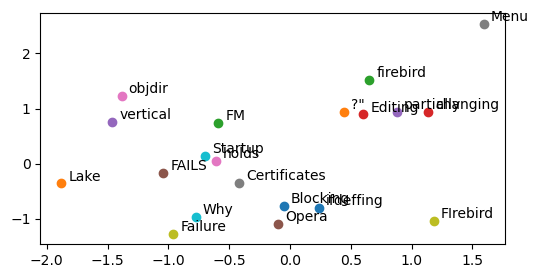

In [94]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [96]:
Lake = get_embed('Lake')
Menu = get_embed('Menu')
Photo = get_embed('Photo')

In [97]:
from scipy import spatial

def cosine_similarity(word1, word2):
    '''
        cosine_similarity function accepts the embeddings of two words and returns the 
        the degree of similarity between them using scipy.
    '''
    cos_sim = 1 - spatial.distance.cosine(word1, word2)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

In [99]:
skipgram_Lake_Menu = cosine_similarity(Lake, Menu)
skipgram_Lake_Photo = cosine_similarity(Menu, Photo)
skipgram_Lake_Lake = cosine_similarity(Lake, Lake)

print(f"Lake vs Menu {skipgram_Lake_Menu}")
print(f"Lake  vs Photo {skipgram_Lake_Photo}")
print(f"Lake  vs Lake  {skipgram_Lake_Lake }" )

Lake vs Menu -0.6810922396697228
Lake  vs Photo -0.5206393277511863
Lake  vs Lake  1


# CBOW
(Counting Bag of Words)

In [100]:
def cbow_random_batch(batch_size,corpus, window_size=1):
    continuous_bag = []
    for sentence in corpus:
        sentence_length = len(sentence)
        for i in range(1, sentence_length-1): 
             target = word2index[sentence[i]]
             outside_word = []
             for ws in range(window_size):
                    ### check if it is outside of range of the list
                    if i + 1 + ws < sentence_length:
                        outside_word.append(word2index[sentence[i+ws+1]])
                    if i - ws - 1 >= 0:
                        outside_word.append(word2index[sentence[(i - ws - 1)]])
             for o in outside_word:
                 continuous_bag.append([o, target])
    # print(len(skipgrams))
    # print(skipgrams[0:10])                
    random_index = np.random.choice(range(len(continuous_bag)), batch_size, replace=False)
             
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([continuous_bag[index][0]]) 
        random_labels.append([continuous_bag[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [101]:
batch_size = 2
input_batch, target_batch = cbow_random_batch(batch_size,corpus_tokenized,2)
print(f"{input.shape}")
print(f"{input=}")
print(f"{label=}")

(2, 1)
input=array([[2057],
       [4175]])
label=array([[ 71],
       [107]])


In [102]:
class CBOW(nn.Module):
    ''' Continuous Bag of words implementation 
        class that accepts the parameter vocabulary
        size and embedding size'''
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        center_word_embed  = self.embedding_center_word(center_word)     
        outside_word_embed = self.embedding_outside_word(outside_word)  
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)    
        
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        
        top_term_exp = torch.exp(top_term) 
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        
        return loss_fn

In [103]:
embedding_size = 2
model = CBOW(len(vocabs), embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [104]:
import time

num_epochs = 5000
start = time.time()

for epoch in range(num_epochs):
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized,2)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time {end - start} ")

Epoch 1000 | Loss: 8.590070 | Time 119.93252897262573 
Epoch 2000 | Loss: 7.907104 | Time 239.36246800422668 
Epoch 3000 | Loss: 15.558704 | Time 362.4038610458374 
Epoch 4000 | Loss: 5.968956 | Time 484.16247820854187 
Epoch 5000 | Loss: 15.043471 | Time 611.1800529956818 


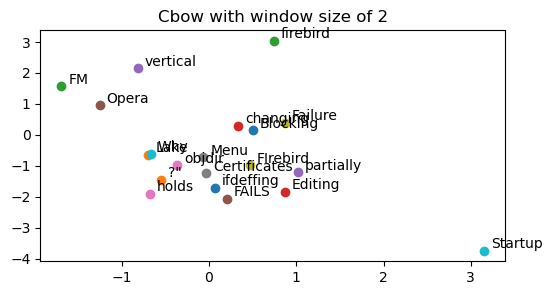

In [105]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.title('Cbow with window size of 2')
plt.show()

In [106]:
#Save Model
path = 'CBOWModel.pth'
torch.save(model.state_dict(), path)

In [107]:
skipgram_Lake_Menu = cosine_similarity(Lake, Menu)
skipgram_Lake_Photo = cosine_similarity(Menu, Photo)
skipgram_Lake_Lake = cosine_similarity(Lake, Lake)

print(f"Lake vs Menu {skipgram_Lake_Menu}")
print(f"Lake  vs Photo {skipgram_Lake_Photo}")
print(f"Lake  vs Lake  {skipgram_Lake_Lake }" )

Lake vs Menu -0.6810922396697228
Lake  vs Photo -0.5206393277511863
Lake  vs Lake  1


# comparing skipgrams vs. negative sampling

In [117]:
#count all the occurrences of vocabs
from collections import Counter
z = 0.001

word_count = Counter(flatten(corpus_tokenized))
# word_count

In [118]:
num_total_words = sum([c for w, c in word_count.items()])
# num_total_words
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

In [119]:
Counter(unigram_table)

Counter({'firebird': 10,
         'changing': 3,
         'Menu': 3,
         'partially': 1,
         'check': 1,
         'colors': 1,
         'correctly': 3,
         'given': 1,
         'Extension': 2,
         'Window': 3,
         'screen': 5,
         'tried': 1,
         'block': 1,
         'data': 2,
         'box': 7,
         'sheet': 1,
         'work': 16,
         'Find': 4,
         'imported': 1,
         'switch': 2,
         'called': 2,
         'stops': 3,
         'manager': 7,
         'RFE': 1,
         'that': 6,
         'my': 4,
         'Message': 1,
         'from': 20,
         'engine': 1,
         '4': 3,
         'HTTP': 1,
         'don': 6,
         'Dialog': 2,
         'gtk2': 1,
         'moved': 1,
         'find': 2,
         'preferences': 7,
         'below': 1,
         'disappears': 2,
         'having': 1,
         'building': 1,
         'viewing': 2,
         'Customization': 1,
         '(': 26,
         'restart': 2,
         'Open': 5

### Negative sampling

In [120]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

### Testing the negative sampling

In [121]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [122]:
target_batch.shape

torch.Size([2, 1])

In [123]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[1395, 2457, 1613],
        [3402,  190,   76]])

In [126]:
target_batch[1]

tensor([1973])

## Model

In [128]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

## Training

In [129]:
batch_size = 2
emb_size = 2 #usually, this can be 50, 100, or 300
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)
num_neg = 10
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [131]:
import time

num_epochs = 5000
start = time.time()

for epoch in range(num_epochs):
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized,2)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, num_neg)  

    optimizer.zero_grad()  
    
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time {end - start} ")

Epoch 1000 | Loss: 6.974865 | Time 130.90534138679504 
Epoch 2000 | Loss: 10.029542 | Time 255.30597400665283 
Epoch 3000 | Loss: 0.892440 | Time 371.2633080482483 
Epoch 4000 | Loss: 3.984993 | Time 489.1211712360382 
Epoch 5000 | Loss: 11.747855 | Time 608.117641210556 


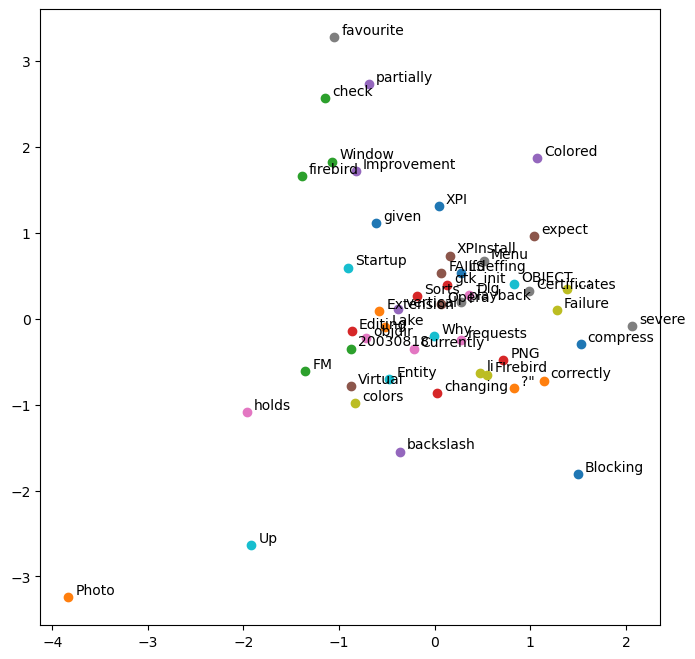

In [132]:
#help me plot fruit cat banana on matplotlib
plt.figure(figsize=(8,8))
for i, word in enumerate(vocabs[:50]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [135]:
#Save Model

path = 'NegSkipgramsModel.pth'
torch.save(model.state_dict(), path)